In [1]:
#pip install regressors

In [2]:
import pandas_datareader as wb
from pandas_datareader import data
import yfinance as yf
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from lxml import html
import datetime
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import norm
from tqdm.notebook import tqdm
import os
from sklearn import linear_model

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy import stats
from regressors import stats as st

In [58]:
def get_treasury_rate():
    
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    r = requests.get(url)
    html = r.text

    soup = BeautifulSoup(html)
    table = soup.find('table', {"class": "t-chart"})
    rows = table.find_all('tr')
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])

        result = pd.DataFrame(data, columns=['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])

    return(result)



def return_df(close_price_df):
        
    return_df = close_price_df.pct_change().apply(lambda x: np.log(1+x))
    
    return return_df

def dummies_beater(all_returns,Rf, option = "return"):
    
    all_returns = all_returns.dropna(how="all")
    Rm = all_returns["SPY"]
    Rm = Rm.fillna(0)
    comps_R = all_returns.drop(columns = ["SPY"])
    comps_R = comps_R.fillna(0)
    
    if option == "return":
        comps_R_excess = comps_R.subtract(Rm.values, axis=0)
        dummies_Return_beaters = comps_R_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    elif option == "sharpe":
        market_volatility = Rm.std()
        comps_volatility = comps_R.std()
        comps_sharpe = (comps_R - Rf)/comps_volatility
        market_sharpe = (Rm - Rf)/market_volatility
        sharpe_excess = comps_sharpe.subtract(market_sharpe, axis=0)
        dummies_Return_beaters = sharpe_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    return dummies_Return_beaters

def port_simulation(stock_closed_df):
    
    pct_change_df = stock_closed_df.pct_change()
    ind_er = pct_change_df.mean()
    return_df = pct_change_df.apply(lambda x: np.log(1+x))
    cov_matrix = return_df.cov()
    
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    
    
    num_assets = len(stock_closed_df.columns)
    num_portfolios = 10000

    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var)  
        p_vol.append(sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
 
    for counter, symbol in enumerate(stock_closed_df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
        portfolios  = pd.DataFrame(data)
        
    return portfolios

def portfolios_return_df(equity_selection, all_return):
    
    simulation = port_simulation(equity_selection)
    weight_possibility = simulation.drop(columns=["Returns", "Volatility"])
    portfolio_return_df = pd.DataFrame(columns = weight_possibility.index)
    port_comps_return = all_return[weight_possibility.columns]
    
    for portfolio in tqdm(weight_possibility.index):
        portfolio_return = weight_possibility.iloc[portfolio].mul(port_comps_return).T.sum()
        portfolio_return_df[portfolio] = portfolio_return
    
    return portfolio_return_df


In [72]:
def FF_assign_label(index_comp_info):
        
        
    index_comp_info["bookToMarket"] = 1/index_comp_info["PB_ratio"]
    index_comp_info["Small_Big_Cap"] = index_comp_info["mkt_cap"].map(lambda x: "B" if x >= index_comp_info["mkt_cap"].median() else "S")
    
    lower, upper = index_comp_info["bookToMarket"].quantile([0.3, 0.7])
    index_comp_info["HML_BP"] = index_comp_info["bookToMarket"].map(lambda x: "H" if x >= upper else "M")
    index_comp_info["HML_BP"] = index_comp_info.apply(lambda row: "L" if row["bookToMarket"] <= lower else row["HML_BP"], axis = 1)
    
    lower_roe, upper_roe = index_comp_info["ROE"].quantile([0.3, 0.7])
    index_comp_info["RNW_ROE"] = index_comp_info["ROE"].map(lambda x: "R" if x >= upper_roe else "N")
    index_comp_info["RNW_ROE"] = index_comp_info.apply(lambda row: "W" if row["ROE"] <= lower_roe else row["RNW_ROE"], axis = 1)
    
    lower_invest, upper_invest = index_comp_info["Asset_growth"].quantile([0.3, 0.7])
    index_comp_info["ANC_investment"] = index_comp_info["Asset_growth"].map(lambda x: "A" if x >= upper_invest else "N")
    index_comp_info["ANC_investment"] = index_comp_info.apply(lambda row: "C" if row["Asset_growth"] <= lower_invest else row["ANC_investment"], axis = 1)
            
    return index_comp_info
        
def FF_factor_classifier(index_comp_info_with_label):
        
    data = index_comp_info_with_label
    Small_Low = data.query('(Small_Big_Cap=="S") & (HML_BP=="L")')
    Small_Mid = data.query('(Small_Big_Cap=="S") & (HML_BP=="M")')
    Small_High = data.query('(Small_Big_Cap=="S") & (HML_BP=="H")')
    
    Small_Weak = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="W")')
    Small_Neutral_Profit = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="N")')
    Small_Robust = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="R")')
    
    Small_Conservative =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="C")')
    Small_Neutral_Invest =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="N")')
    Small_Aggresive =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="A")')
    
    Big_Low = data.query('(Small_Big_Cap=="B") & (HML_BP=="L")')
    Big_Mid = data.query('(Small_Big_Cap=="B") & (HML_BP=="M")')
    Big_High = data.query('(Small_Big_Cap=="B") & (HML_BP=="H")')
    
    Big_Weak = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="W")')
    Big_Neutral_Profit = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="N")')
    Big_Robust = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="R")')

    Big_Conservative =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="C")')
    Big_Neutral_Invest = data.query('(Small_Big_Cap=="B") & (ANC_investment=="N")')
    Big_Aggresive =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="A")')
    
    each_groups_list = [Small_Low, Small_Mid, Small_High, 
                            Small_Weak, Small_Neutral_Profit, Small_Robust,
                            Small_Conservative, Small_Neutral_Invest, Small_Aggresive,
                            Big_Low, Big_Mid,Big_High,
                            Big_Weak, Big_Neutral_Profit, Big_Robust,
                            Big_Conservative, Big_Neutral_Invest, Big_Aggresive]
        
    return each_groups_list
    
def FF_classes_return(market_components_return, list_of_group_info, axis=True):
        
    groups_names = ["Small_Low", "Small_Mid", "Small_High",
                        "Small_Weak", "Small_Neutral_Profit", "Small_Robust",
                        "Small_Cons", "Small_Neutral_Invest", "Small_Aggr",
                        "Big_Low", "Big_Mid","Big_High",
                        "Big_Weak", "Big_Neutral_Profit", "Big_Robust",
                        "Big_Cons", "Big_Neutral_Invest", "Big_Aggr"]
    
    df_groups = pd.DataFrame(columns = groups_names)
    
    counter = 0
    
    for group in list_of_group_info:
    
        group_cap = group["mkt_cap"].T
        group_total_cap = group["mkt_cap"].sum()
        group_cap_multi_return = group_cap*market_components_return[list(group.index)]
        
        if axis == True:
            df_groups[groups_names[counter]] = group_cap_multi_return.apply(lambda row: row.sum()/group_total_cap, axis=1)
        
        else:
            groups_index_return = group_cap_multi_return.sum()/group_total_cap
            df_groups[groups_names[counter]] = [groups_index_return]
    
        counter += 1
                
    return df_groups
    
def FF_calc_factors(classes_return_df, df = True):
    
    factor_name = ["SMB", "HML", "RMW", "CMA"]
    
    SMB_BP = (classes_return_df["Small_Low"] + classes_return_df["Small_Mid"] 
                      + classes_return_df["Small_High"]) - (classes_return_df["Big_Low"]
                      + classes_return_df["Big_Mid"] + classes_return_df["Big_High"])/3
    
    SMB_PFT = (classes_return_df["Small_Weak"] + classes_return_df["Small_Neutral_Profit"] 
                      + classes_return_df["Small_Robust"]) - (classes_return_df["Big_Weak"]
                      + classes_return_df["Big_Neutral_Profit"] + classes_return_df["Big_Robust"])/3
    
    SMB_INV = (classes_return_df["Small_Cons"] + classes_return_df["Small_Neutral_Invest"] 
                      + classes_return_df["Small_Aggr"]) - (classes_return_df["Big_Cons"]
                      + classes_return_df["Big_Neutral_Invest"] + classes_return_df["Big_Aggr"])/3
    
    if df == True:
        
        FF_factors_data = pd.DataFrame(columns = factor_name)
        
    
    FF_factors_data["SMB"] = (SMB_BP + SMB_PFT + SMB_INV)/3
    
    FF_factors_data["HML"] = (classes_return_df["Small_High"] + classes_return_df["Big_High"]
                      - (classes_return_df["Small_Low"] + classes_return_df["Big_Low"])) / 2
    
    FF_factors_data["RMW"] = (classes_return_df["Small_Robust"] + classes_return_df["Big_Robust"]
                      - (classes_return_df["Small_Weak"] + classes_return_df["Big_Weak"])) / 2
    
    FF_factors_data["CMA"] = (classes_return_df["Small_Cons"] + classes_return_df["Big_Cons"]
                      - (classes_return_df["Small_Aggr"] + classes_return_df["Big_Aggr"])) / 2
        
    return FF_factors_data

    
def FF_regress(FF_factors_df, target_comp_risk_premium):
            
    y = target_comp_risk_premium
    X = FF_factors_df
    model = linear_model.LinearRegression()
    model.fit(X.astype(float), y.astype(float))
    params = np.append(model.intercept_,model.coef_)
    predictions = model.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    #print(newX)
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(X.columns)))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard_Errors"],myDF3["t_stat"],myDF3["P_value"] = [params,sd_b,ts_b,p_values]
    
    return myDF3
    

def regressAll(FF_factors, all_returns, days, train_base=2000, Rf=Rf):
    
    
    dummies_Return_beaters = dummies_beater(all_returns, Rf)
    
    prob_10obs = dummies_Return_beaters.iloc[days - 10 : days].mean().T
    prob_20obs = dummies_Return_beaters.iloc[days - 20 : days].mean().T
    prob_30obs = dummies_Return_beaters.iloc[days - 30 : days].mean().T

    target = dummies_Return_beaters.iloc[days+1]
    
    features_df = pd.DataFrame(columns = ["const",'B1', 'B2', 'B3', 'B4', 'B5',"Pval_C", "Pval1", "Pval2", "Pval3", "Pval4", "Pval5"],
                               index = all_returns.columns)
    
    comps_R = all_returns.drop(columns = ["SPY"]).fillna(0)
    FF_factors = FF_factors.fillna(0)
    for i in comps_R:
        
        regression_stat = FF_regress(FF_factors.iloc[days-train_base:days], comps_R[i].iloc[days-train_base:days])
        betas = list(regression_stat["Coefficients"])
        Pvals = list(regression_stat["P_value"])
        features = betas + Pvals
        features_df.loc[i] = features
    
    features_df["prob_10obs"], features_df["prob_20obs"], features_df["prob_30obs"] = [prob_10obs, prob_20obs, prob_30obs]
    features_df["true_target"] = target
    
    
    return features_df


    

Frequency: 30 min and 2 min

Time series Beta estimation: Measure 5 betas for each 30 min, using 2 min frequency. (Need to know how betas change every 30 min)

Plan B:
1) Use historical return data (2m or higher frequency) of 505 companies in SP500 index to run FF for each company.

2) Calculate probability of beating market in certain period (if APPL 2m Sharpe beated the market 5 times in last 30 min, prob of beating is 5/15 = 0.333).

3) put 1) and 2) together to get a all companies' prob of winning in given period and their Betas.

4) Model probability from 3)

5) Caculate Betas for all 10,000 simulated potfolio

6) get the probability of winning

How to make it predictive?

Model Construction: This may not work

1) model the probability of 30 min winning with 5 betas(5 features) we eatimate every 30 min. (can use SVM, decision tree, regression...)

2) measure betas of winner-loser portfolios spread for same time length for our portolios

3) plug betas of portfolios to the model in 1)

4) model true prob of winning of portfolios on fitted value from 3)

5) make analyical model to preidictive model

The reason we estimate the probability of picking a winner portfolio with given beta is because as we move from Time(T) T1 to T2, the stock price changes, so our weight also changes. We are essensially move from one simulated portfolio to another simulated portfolio as the time goes.


What ML can apply here?

What would the result be if use unsupervised grouping to caculate factors? (Maybe useful when FF doesn't explain well in term of R^2)

Any potential non-linear relationship?

How to optimize time scale to ensure the highest predictive ability? or would models' ability consistant accross time series mapping?

How to test predictivity?

Any trade off between high winning prob and portfolio sharpe?

# Data Collection

In [6]:
print(os.getcwd())
print(os.listdir(os.getcwd()))

/Users/liuhengjia/Desktop/css100_project
['CSS100.ipynb', '.DS_Store', '.ipynb_checkpoints']


In [7]:
os.chdir("/Users/liuhengjia/Desktop")

In [8]:
FF_info = pd.read_csv("data/Fama_French_info.csv", index_col = 0)

In [9]:
str1 = ' '
index_list = FF_info.index.tolist()
index_list.append("SPY")
#index_list.reverse()
total_string = str1.join(index_list)

In [169]:
#SPYn500_30m_df = yf.download(total_string, start = '2021-10-11', end = "2021-11-18", interval = '30m')
#SPYn500_2m_df = yf.download(total_string, start = '2021-10-11', end = "2021-11-18", interval = '2m')

In [53]:
#SPYn500_30m_df["Adj Close"].to_csv("SPYn500_30m_close.csv")
#SPYn500_2m_df["Adj Close"].to_csv("SPYn500_2m_close.csv")

In [10]:
sp_2m_close = pd.read_csv("data/SPYn500_2m_close.csv", index_col = 0)
#sp_30m_close = pd.read_csv("data/SPYn500_30m_close.csv", index_col = 0)

In [11]:
sp_2m_close.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:30:00-04:00,150.729996,20.120001,214.000000,141.949997,111.199997,120.519997,333.580200,118.260002,324.829987,571.551025,...,61.740002,154.020004,62.622299,58.139999,121.169998,123.730003,146.309998,492.0,64.209999,196.289993
2021-10-11 09:32:00-04:00,150.690002,20.020000,213.889999,142.850006,111.160004,121.260002,333.104889,118.154999,325.119995,574.900024,...,62.064999,155.339996,62.560001,58.119999,121.239998,123.787201,146.315002,NaN,63.900002,196.509995
2021-10-11 09:34:00-04:00,151.330002,19.870001,214.000000,142.889999,111.129997,121.184998,335.989990,118.599998,324.910004,575.900024,...,62.360001,155.895004,62.556599,58.000000,120.980003,123.180000,NaN,NaN,63.650002,196.820007


# Calculate log-return (assuming return is log-normal) for both time interval

In [16]:
total_2m_return = return_df(sp_2m_close)
#total_30m_return = return_df(sp_30m_close)

In [14]:
total_2m_return = total_2m_return.dropna(how = "all")

In [15]:
total_2m_return.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,-0.000265,-0.004983,-0.000514,0.006320,-0.000360,0.006121,-0.001426,-0.000888,0.000892,0.005842,...,0.005250,0.008534,-0.000995,-0.000344,0.000578,0.000462,0.000034,0.000000,-0.00484,0.001120
2021-10-11 09:34:00-04:00,0.004238,-0.007521,0.000514,0.000280,-0.000270,-0.000619,0.008624,0.003759,-0.000646,0.001738,...,0.004742,0.003566,-0.000054,-0.002067,-0.002147,-0.004917,0.000000,0.000000,-0.00392,0.001576
2021-10-11 09:36:00-04:00,-0.004039,0.002789,-0.000187,-0.001891,0.000315,0.003336,0.000000,-0.003886,0.000062,-0.001808,...,-0.000802,0.000673,0.003406,-0.001035,0.001280,0.000244,0.001264,0.002923,0.00157,-0.000762


# Defining components return, market return, dummies beater

In [22]:
sp500_2m_return = total_2m_return.drop(columns=["SPY"])

In [19]:
#Rm_30m = total_30m_return[['SPY']]
Rm_2m = total_2m_return[['SPY']]
Rm_2m = Rm_2m.dropna(how="all")
#We need to discount Monthly Rf to 2m and 30m Rf using yield curve(continuously compounded)
Rf = 0.000001

In [20]:
dummies_2m_beater = dummies_beater(total_2m_return, Rf, option="sharpe")

## Feature Engineering

### Calculate FF factors

In [23]:
FF_info_labeled = FF_assign_label(FF_info)
FF_classified_list = FF_factor_classifier(FF_info_labeled)
FF_2m_classes_return = FF_classes_return(sp500_2m_return,FF_classified_list)
FF_2m_factor = FF_calc_factors(FF_2m_classes_return)
FF_2m_factor["Rm-Rf"] = Rm_2m - Rf

In [385]:
#equity_selection = sp_2m_close.drop(columns=["SPY"]).sample(n=10, axis="columns")
#portfolio_2m_return = portfolios_return_df(equity_selection, total_2m_return)
#portfolio_2m_return.to_csv("portfolio_2m_return.cvs")

In [61]:
portfolio_2m_return = pd.read_csv("data/portfolio_2m_return.csv", index_col = 0)

In [104]:
portfolio_2m_return

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,0.002946,0.000775,0.002976,0.001952,0.002269,0.002233,0.001302,0.000822,2.105255e-03,0.002878,...,0.001616,0.002435,0.001814,0.002312,0.003024,0.002614,0.001487,0.002442,0.002067,0.002400
2021-10-11 09:34:00-04:00,-0.001580,-0.001239,-0.000832,-0.001587,-0.001015,-0.001145,-0.001873,-0.002047,-1.419887e-03,-0.001425,...,-0.001030,-0.001780,-0.001520,-0.001318,-0.001535,-0.001486,-0.001682,-0.001358,-0.000840,-0.001033
2021-10-11 09:36:00-04:00,-0.000649,0.000077,-0.001031,-0.000491,-0.000485,-0.000369,0.000273,0.000290,-6.997251e-04,-0.000637,...,-0.000243,-0.000556,-0.000054,-0.000606,-0.000932,-0.000591,-0.000006,-0.000669,-0.000153,-0.000483
2021-10-11 09:38:00-04:00,0.001063,0.000156,0.000513,0.000427,0.000628,0.000912,0.000032,0.000030,6.791499e-04,0.001398,...,0.000543,0.000609,0.000308,0.001173,0.001641,0.001176,0.000158,0.001121,0.000388,0.000797
2021-10-11 09:40:00-04:00,0.000250,0.000255,0.000098,0.000143,0.000384,0.000238,0.000692,0.000233,6.189725e-05,0.000197,...,0.000014,0.000203,0.000661,-0.000008,0.000135,0.000065,0.000429,0.000051,0.000616,0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17 15:50:00-05:00,0.000713,0.001135,0.000463,0.000413,0.000944,0.001046,0.000765,0.000588,6.826335e-04,0.001100,...,0.000886,0.000354,0.000854,0.001263,0.000956,0.000888,0.000856,0.000938,0.000970,0.001246
2021-11-17 15:52:00-05:00,0.000136,-0.000091,-0.000186,-0.000075,-0.000072,-0.000206,0.000214,-0.000010,1.163566e-07,-0.000015,...,-0.000302,-0.000113,0.000313,-0.000184,0.000135,-0.000094,-0.000176,0.000207,0.000075,-0.000088
2021-11-17 15:54:00-05:00,-0.000084,0.000045,0.000076,-0.000109,0.000111,-0.000005,0.000038,-0.000220,-6.398557e-07,-0.000022,...,-0.000169,-0.000071,0.000074,0.000061,0.000023,-0.000176,-0.000192,0.000110,0.000173,0.000214


In [64]:
portfolio_2m_return_Rm = portfolio_2m_return.copy()
portfolio_2m_return_Rm["SPY"] = total_2m_return["SPY"]

In [107]:
def performence_df(FF_2m_factor,total_2m_return, portfolio_2m_return_Rm):

    performence = pd.DataFrame(columns=["precision", "recall", "f1"])

    days = 2000

    while days < len(portfolio_2m_return_Rm)-1:
    
        portfolio_feature = regressAll(FF_2m_factor,portfolio_2m_return_Rm, days ,2000)
        
        portfolio_feature = portfolio_feature.drop(index=["SPY"]).fillna(0)
        
        XYtrain = regressAll(FF_2m_factor,total_2m_return,days,2000)
        XYtrain = XYtrain.fillna(0)
        
        
        sgd_clf = SGDClassifier(random_state = 42)
        model = sgd_clf.fit(XYtrain.drop(columns=["true_target"]),XYtrain["true_target"])
    
        prediction = model.predict(portfolio_feature.drop(columns=["true_target"]))
        portfolio_feature["prediction"] = prediction
    
        precision = precision_score(portfolio_feature["true_target"], portfolio_feature["prediction"])
        recall = recall_score(portfolio_feature["true_target"], portfolio_feature["prediction"])
        f1 = f1_score(portfolio_feature["true_target"], portfolio_feature["prediction"])
    
        score_series = pd.Series([precision, recall, f1], index = performence.columns)
        performence = performence.append(score_series, ignore_index=True)
    
        days += 1
    
    return performence

In [ ]:
p1 = performence_df(FF_2m_factor,total_2m_return, portfolio_2m_return_Rm)

In [98]:
sgd_clf = SGDClassifier(random_state = 42)
model = sgd_clf.fit(XYtrain.drop(columns=["true_target"]),XYtrain["true_target"])

## Feature Engineering

In [110]:
sp500_2m_return = total_2m_return.dropna(how = "all")

In [ ]:
#combine betas measured above with 15 min prob of beating

In [165]:
#Regress prob of beating on observed betas

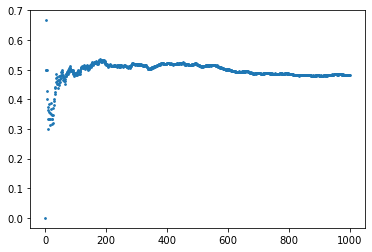

In [222]:
time_length = range(len(dummies_2m_beaters.index[:1000]))
winner_rate_list = []
for length in tqdm(time_length):
    winner_rate = dummies_2m_beaters["GE"].iloc[:length].mean()
    winner_rate_list.append(winner_rate)
    
plt.scatter(time_length, winner_rate_list, s=3)

In [113]:
FF_regress(FF_2m_factor.fillna(0),sp500_2m_return["AAPL"].fillna(0)-Rf )

,Coefficients,Standard_Errors,t_stat,P_value
0,0.0000,0.000,0.325,0.745
1,-0.3181,0.012,-27.628,0.000
2,-0.4702,0.022,-21.839,0.000
3,0.6130,0.024,25.985,0.000
4,1.4745,0.030,49.400,0.000
5,1.6016,0.027,59.141,0.000


In [121]:
regressAll(FF_2m_factor.fillna(0), total_2m_return.fillna(0)-Rf, days=2000)

,const,B1,B2,B3,B4,B5,Pval_C,Pval1,Pval2,Pval3,Pval4,Pval5,prob_10obs,prob_20obs,prob_30obs,true_target
A,-0,0.1934,-0.0134,0.7876,-0.3618,0.826,0.672,0,0.837,0,0,0,0.6,0.60,0.566667,1.0
AAL,-0.0001,0.5723,-0.9244,-2.7082,-0.8702,0.2369,0.008,0,0,0,0,0.006,0.4,0.45,0.400000,0.0
AAP,0,0.4221,-0.0521,-0.2898,-0.5668,-0.0148,0.472,0,0.456,0.002,0,0.837,0.4,0.45,0.466667,1.0
AAPL,0,-0.2842,-0.6598,0.3186,1.3531,1.5517,0.427,0,0,0,0,0,0.5,0.50,0.500000,1.0
ABBV,-0,-0.0153,0.4162,0.7164,0.5771,0.4517,0.35,0.483,0,0,0,0,0.7,0.60,0.600000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0,0.1998,-0.2501,-0.1885,-0.0729,0.3997,0.516,0,0,0.002,0.212,0,0.1,0.20,0.266667,0.0
ZBH,-0,0.2268,-0.3001,0.1714,0.2894,0.4948,0.844,0,0,0.068,0.002,0,0.4,0.60,0.566667,1.0
ZBRA,0,0.4522,-0.3937,0.4824,-0.2676,0.1336,0.831,0,0,0,0.007,0.081,0.4,0.50,0.600000,0.0
ZION,0,0.3325,1.379,-0.2603,-0.6315,0.3363,0.756,0,0,0.008,0,0,0.5,0.50,0.466667,0.0
